In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-09-03 01:03:56.502259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 01:03:56.502366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 01:03:56.644738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.random.set_seed(42)

# DATA LOADING

In [3]:
from tensorflow.keras.datasets import mnist

(full_X_train, full_y_train), (X_test, y_test) = mnist.load_data()
full_X_train, X_test = full_X_train/255., X_test/255.
X_train, y_train = full_X_train[10000:], full_y_train[10000:]
X_val, y_val = full_X_train[:10000], full_y_train[:10000]
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_train.shape, X_test.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((50000, 28, 28, 1), (10000, 28, 28, 1))

# DATA PREPARATION

In [4]:
def mnist_dataset(X, y, batch_size=32, shuffle_buffer=None, cache=None, n_reads=tf.data.AUTOTUNE):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)


train_set = mnist_dataset(X_train, y_train, cache=True, shuffle_buffer=10_000)
valid_set = mnist_dataset(X_val, y_val)
test_set = mnist_dataset(X_test, y_test)

# VISUALIZING A FEW DATASET AND PERFORMING DATA UGMENTATION

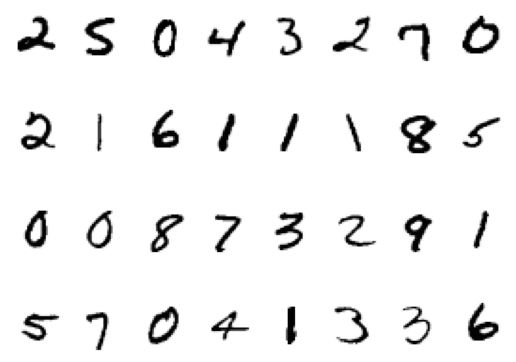

In [5]:
def plot_digits(dataset):
    for batch in dataset:
        for idx, instance_n_label in enumerate(batch[0]):
            ax = plt.subplot(4, 8, idx+1)
            ax.imshow(tf.reshape(instance_n_label, shape=(28, 28)), cmap='Greys')
            ax.axis('off')
        plt.show()

digits = train_set.take(1)
plot_digits(digits)

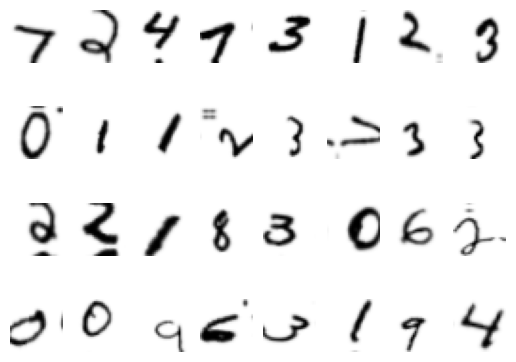

In [6]:
# Applying Data Augmentation

augment = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(factor=0.1),
            tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
            tf.keras.layers.RandomBrightness(factor=0),
            tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

# print(digits.shape)
digit2 = digits.map(lambda X, y: (augment(X), y))
plot_digits(digit2)

In [7]:
def early_stopping_callback(patience=5, monitor='val_accuracy', mode='max', 
                            restore_best_weights=True, min_delta=0.001, **kwargs):
    return tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, mode=mode, 
                                            restore_best_weights=restore_best_weights,min_delta=min_delta, **kwargs)

# Building The Model

In [8]:
tf.random.set_seed(42)
np.random.seed(42)
n_filters = 10
padding='valid'
input_shape = [28, 28, 1]
n_classes = 10
kernel_init = 'he_normal'

model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu',
                           kernel_initializer=kernel_init, padding=padding),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=n_filters+n_filters, kernel_size=(3,3), activation='relu',
                           kernel_initializer=kernel_init),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
], name='model1')

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu',
                           kernel_initializer=kernel_init, padding=padding),
    tf.keras.layers.MaxPool2D(padding=padding),
     tf.keras.layers.Conv2D(filters=n_filters+n_filters, kernel_size=(3,3),activation='relu',
                           kernel_initializer=kernel_init),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(n_classes, activation='softmax')
], name='model2')

input_layer1 = tf.keras.layers.Input(shape=input_shape)
input_layer2 = tf.keras.layers.Input(shape=input_shape)
output1 = model1(input_layer1)
output2 = model2(input_layer2)

model = tf.keras.models.Model(inputs=[input_layer1, input_layer2],
                                     outputs=[output1, output2])

# for layers in model1.layers
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'accuracy']
)

model.summary()

checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint(filepath='best_model1.keras',
                                                   monitor='val_model1_accuracy',
                                                   save_best_only=True,
                                                   save_weights_only=False,
                                                   mode='max',
                                                   verbose=0,
                                                   )

checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.keras',
                                                    monitor='val_model2_accuracy',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    mode='max',
                                                    verbose=0)
                                                      

with tf.device('/CPU:0'):
    aug_train_set = train_set.map(lambda X, y: (((X, augment(X)),(y,y)) ),
                                  num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)

    aug_valid_set = valid_set.map(lambda X, y: (((X, X),(y,y)) ),
                                  num_parallel_calls=tf.data.AUTOTUNE).prefetch(1)

with tf.device('/GPU:0'):
    hystory= model.fit(aug_train_set, epochs=20,
                       validation_data=aug_valid_set,
                      callbacks=[checkpoint_cb1, checkpoint_cb2, 
                                 early_stopping_callback(monitor='val_model1_accuracy', start_from_epoch=3),
                                 early_stopping_callback(monitor='val_model2_accuracy', start_from_epoch=3)])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model1 (Sequential) │ (None, 10)        │      6,930 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ model2 (Sequential) │ (None, 10)        │      6,930 │ input_layer_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,860 (54.14 KB)

 Trainable params: 13,860 (54.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2024-09-03 01:04:18.514674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.46381, expected 1.53764
2024-09-03 01:04:18.514735: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.93125, expected 1.00508
2024-09-03 01:04:18.514744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.92955, expected 1.00338
2024-09-03 01:04:18.514752: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.34846, expected 1.42229
2024-09-03 01:04:18.514760: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.165, expected 2.23883
2024-09-03 01:04:18.514768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.69572, expected 1.76955
2024-09-03 01:04:18.514776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.1102, expected 2.18403
2024-09-03 01:04:18.514783: E external/local_xla/xla/servi

  38/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.5406 - model1_accuracy: 0.2295 - model2_accuracy: 0.1049

I0000 00:00:1725325460.516370      65 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0540 - model1_accuracy: 0.8549 - model2_accuracy: 0.4606

2024-09-03 01:04:25.983405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.7038, expected 1.00161
2024-09-03 01:04:25.983468: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.03148, expected 1.32929
2024-09-03 01:04:25.983477: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.31276, expected 1.61057
2024-09-03 01:04:25.983485: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.0474, expected 1.34521
2024-09-03 01:04:25.983503: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.43966, expected 1.73747
2024-09-03 01:04:25.983511: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.96142, expected 2.25923
2024-09-03 01:04:25.983519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1.94734, expected 1.24515
2024-09-03 01:04:25.983526: E external/local_xla/xla/serv

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.0516 - model1_accuracy: 0.8552 - model2_accuracy: 0.4612 - val_loss: 0.4764 - val_model1_accuracy: 0.9676 - val_model2_accuracy: 0.8892
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8779 - model1_accuracy: 0.9727 - model2_accuracy: 0.7479 - val_loss: 0.4039 - val_model1_accuracy: 0.9763 - val_model2_accuracy: 0.9071
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6903 - model1_accuracy: 0.9796 - model2_accuracy: 0.8076 - val_loss: 0.4369 - val_model1_accuracy: 0.9742 - val_model2_accuracy: 0.9018
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5992 - model1_accuracy: 0.9830 - model2_accuracy: 0.8282 - val_loss: 0.4043 - val_model1_accuracy: 0.9810 - val_model2_accuracy: 0.9024
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5408 - model1_accuracy: 0.9847 - model2_accuracy: 0.8480 - val_loss: 0.3644 - val_model1_accuracy: 0.9821 - val_model2_accuracy: 0.9128
Epoch 6/20

In [9]:
best_model1 = tf.keras.models.load_model('best_model1.keras')
best_model1.evaluate(aug_valid_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3031 - model1_accuracy: 0.9863 - model2_accuracy: 0.9358


[0.32209938764572144, 0.9860000014305115, 0.9272000193595886]

In [10]:
best_model2 = tf.keras.models.load_model('best_model2.keras')
best_model2.evaluate(aug_valid_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2484 - model1_accuracy: 0.9850 - model2_accuracy: 0.9480


[0.26270177960395813, 0.9839000105857849, 0.9445000290870667]

In [11]:
model.get_layer('model1').set_weights(best_model1.get_layer('model1').get_weights()) 
model.get_layer('model2').set_weights(best_model2.get_layer('model2').get_weights())
model.evaluate(aug_valid_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2424 - model1_accuracy: 0.9863 - model2_accuracy: 0.9480


[0.25612887740135193, 0.9860000014305115, 0.9445000290870667]

In [12]:
model.save('best_combined_model.keras')

In [13]:
model.get_layer('model1').layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>]

In [14]:
n_neurons = 32
n_classes = 10
start_layer = 0
end_layer = -2

# load best_combined_model
best_combined_model = tf.keras.models.load_model('best_combined_model.keras')

# Retrieve the two modes
mod1 = tf.keras.Sequential(best_combined_model.get_layer('model1').layers[start_layer:end_layer], name='mod1')
mod2 = tf.keras.Sequential(best_combined_model.get_layer('model2').layers[start_layer:end_layer], name='mod2')

# CREATE THE MODEL
input_layer = tf.keras.layers.Input(shape=input_shape)
mod1_with_input = mod1(input_layer)
mod2_with_input = mod2(input_layer)

# Creating the conv layer to replace the combined model softmax layer
conv1 = tf.keras.layers.Conv2D(filters=n_classes, kernel_size=mod1_with_input.shape[1:-1], activation='relu')
conv2 = tf.keras.layers.Conv2D(filters=n_classes, kernel_size=mod2_with_input.shape[1:-1], activation='relu')
conv1_out = conv1(mod1_with_input)
conv2_out = conv2(mod2_with_input)

concat_layer = tf.keras.layers.concatenate([conv1_out, conv2_out])
# max_pool = tf.keras.layers.MaxPool2D()(concat_layer)
flatten = tf.keras.layers.Flatten()(concat_layer)
# dropout_layer1 = tf.keras.layers.Dropout(rate=0.25)(flatten)
dense_1 = tf.keras.layers.Dense(units=n_neurons, activation='relu', kernel_initializer=kernel_init)(flatten)
dropout_layer2 = tf.keras.layers.Dropout(rate=0.5)(dense_1)
ouput = tf.keras.layers.Dense(units=n_classes, activation='softmax')(dropout_layer2)

# Get softmax layer weights for thefirst two models and use it to set the new Conv2D layer weights
model1_dense_weights = best_combined_model.get_layer('model1').layers[-1].get_weights()
model2_dense_weights = best_combined_model.get_layer('model2').layers[-1].get_weights()

# build_model
f_model = tf.keras.models.Model(inputs=[input_layer], outputs=[ouput], name='f_model')

conv1.set_weights([model1_dense_weights[0].reshape(conv1.weights[0].shape), 
                   model1_dense_weights[1].reshape(conv1.weights[1].shape)])

# confirm weight settings (using biases)
print(set(conv1.get_weights()[1] == model1_dense_weights[1]))

f_model.summary() 

{True}


Model: "f_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod1 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod2 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 20)  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,862 (58.05 KB)

 Trainable params: 14,862 (58.05 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# freeze all layers except for the last n layers
n = 2
for layer in f_model.layers[-n:]:
    layer.trainable = False
    

# Compile model
f_model.compile(optimizer='nadam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# train model
f_model.fit(train_set, validation_data=valid_set, epochs=10,
           callbacks=[early_stopping_callback()])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6100 - loss: 1.2489 - val_accuracy: 0.9778 - val_loss: 0.0928
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8610 - loss: 0.3791 - val_accuracy: 0.9826 - val_loss: 0.0731
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8902 - loss: 0.2915 - val_accuracy: 0.9825 - val_loss: 0.0746
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9111 - loss: 0.2320 - val_accuracy: 0.9815 - val_loss: 0.0824
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9265 - loss: 0.1998 - val_accuracy: 0.9862 - val_loss: 0.0792
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9332 - loss: 0.1817 - val_accuracy: 0.9828 - val_loss: 0.0818
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9400 - loss: 0.1665 - val_accuracy: 0.9830 - val_loss: 0.0938
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9468 - loss: 0.1445 -

In [16]:
# unfreeze all layers
for layer in f_model.layers:
    layer.trainable = True

sgd = tf.keras.optimizers.SGD(learning_rate=0.001,
                              momentum=0.9,
                            weight_decay=1e-4,   
                            nesterov=True) 

# Compile model
f_model.compile(optimizer=sgd,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

f_model.summary()

f_model.fit(train_set, validation_data=valid_set, epochs=50,
            callbacks=[early_stopping_callback(patience=10)])

Model: "f_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod1 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod2 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 20)  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,862 (58.05 KB)

 Trainable params: 14,862 (58.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9521 - loss: 0.1367 - val_accuracy: 0.9876 - val_loss: 0.0732
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9678 - loss: 0.0973 - val_accuracy: 0.9871 - val_loss: 0.0747
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9730 - loss: 0.0820 - val_accuracy: 0.9876 - val_loss: 0.0771
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9735 - loss: 0.0789 - val_accuracy: 0.9876 - val_loss: 0.0815
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9737 - loss: 0.0752 - val_accuracy: 0.9880 - val_loss: 0.0814
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9755 - loss: 0.0703 - val_accuracy: 0.9874 - val_loss: 0.0831
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9757 - loss: 0.0686 - val_accuracy: 0.9866 - val_loss: 0.0898
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9757 - loss: 0.0688 -

In [17]:
# Performing Kfold Validation

from  sklearn.model_selection import KFold


kf = KFold(n_splits=6, shuffle=True, random_state=42)
hystory = []
for i, (train_index, valid_index) in enumerate(kf.split(full_X_train)):
    kX_train_set, ky_train_set = full_X_train[train_index], full_y_train[train_index]
    kX_valid_set, ky_valid_set = full_X_train[valid_index], full_y_train[valid_index]

    checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint(filepath=f'kmodel_cv{i}.keras',
                                                   monitor='val_accuracy',
                                                   save_best_only=True,
                                                   save_weights_only=False,
                                                   mode='max',
                                                   verbose=1,
                                                   )
    
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001,
                                  momentum=0.9,
                                  weight_decay=1e-4,   
                                  nesterov=True) 

    # Compile model
    f_model.compile(optimizer=sgd,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

    history = f_model.fit(kX_train_set, ky_train_set, validation_data=(kX_valid_set, ky_valid_set),
                epochs=10, callbacks=[early_stopping_callback(patience=3), checkpoint_cb1])
    hystory.append(history)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9694 - loss: 0.0990
Epoch 1: val_accuracy improved from -inf to 0.99410, saving model to kmodel_cv0.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9694 - loss: 0.0990 - val_accuracy: 0.9941 - val_loss: 0.0285
Epoch 2/10
1556/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9717 - loss: 0.0893
Epoch 2: val_accuracy improved from 0.99410 to 0.99420, saving model to kmodel_cv0.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9717 - loss: 0.0894 - val_accuracy: 0.9942 - val_loss: 0.0291
Epoch 3/10
1559/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.0860
Epoch 3: val_accuracy did not improve from 0.99420
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9725 - loss: 0.0860 - val_accuracy: 0.9940 - val_loss: 0.0309
Epoch 4/10
1541/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9740 - loss: 0.0814
Epoch 4: val_accuracy improved from 0.99420 to 0.99430, saving m

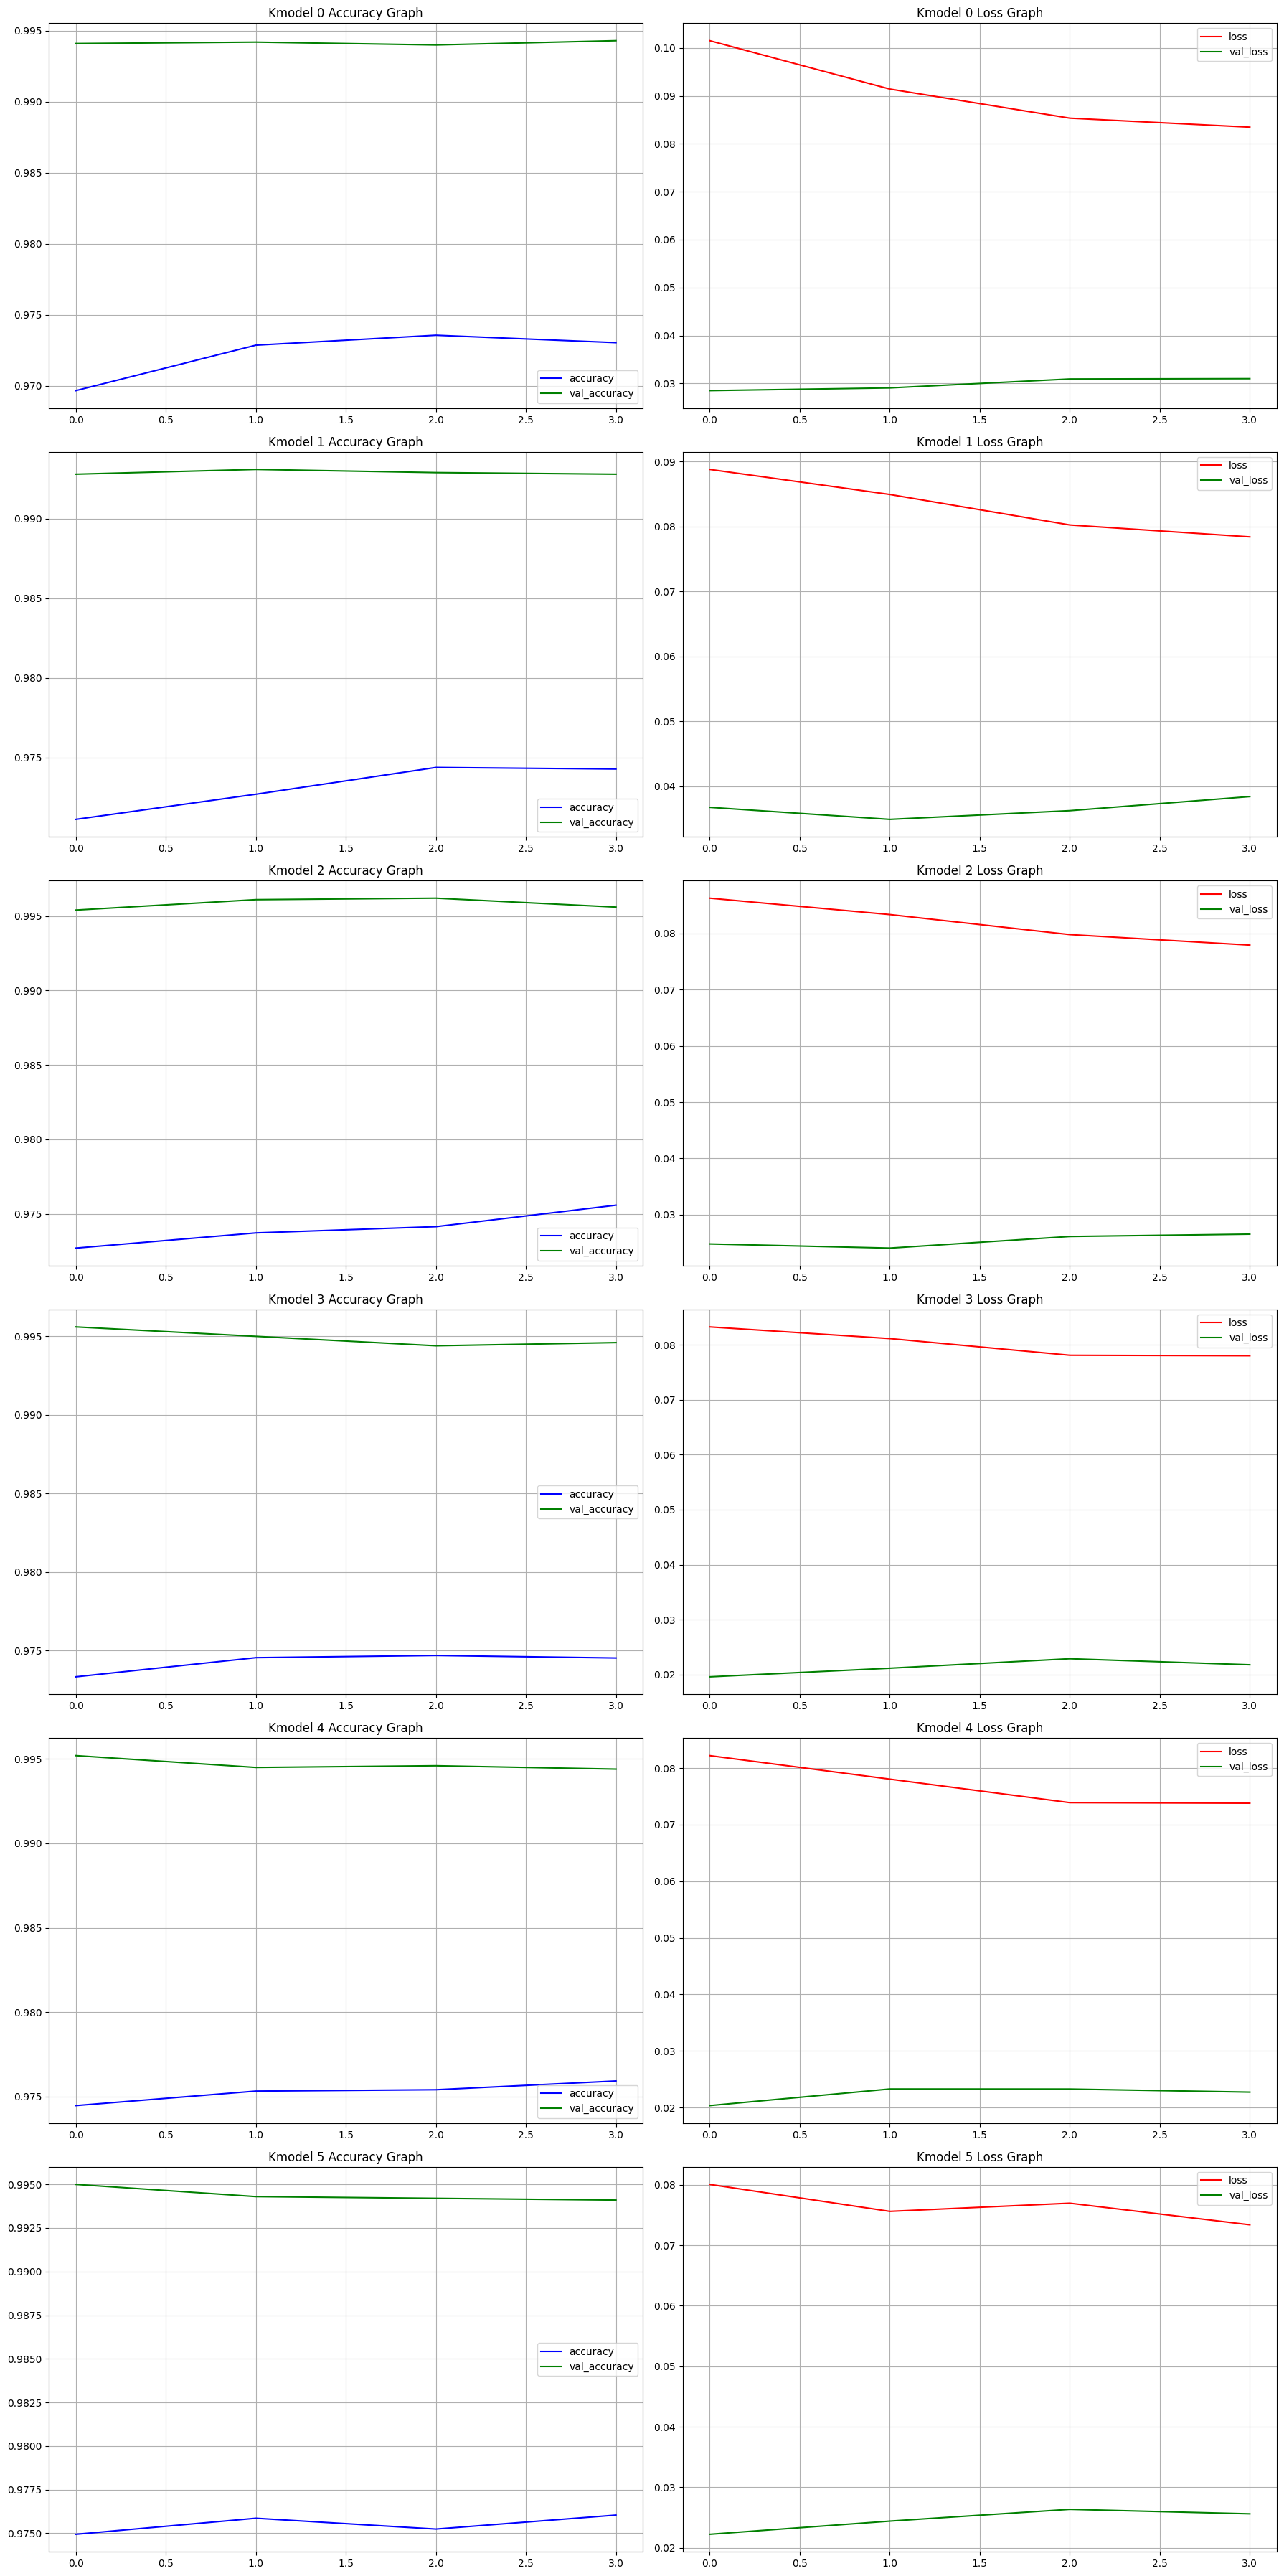

In [18]:
# Plot the history object in other to choose the best model

# for i, hyst in enumerate(hystory):
#     pd.DataFrame(hyst.history).plot(legend=True, grid=True)
#     plt.title(f'histroy graph at epoch {i}')
#     plt.show()
#     break

figure, axes = plt.subplots(6, 2, figsize=(18,36))
axes = axes

for i, hist in enumerate(hystory):
    for j in range(2):
        if j < 1:
            x = list(range(len(hist.history['val_accuracy'])))
            axes[i][j].plot(x, hist.history['accuracy'], label='accuracy', color='blue')
            axes[i][j].plot(x, hist.history['val_accuracy'], label='val_accuracy', color='green')
            axes[i][j].legend()
            axes[i][j].set_title(f'kmodel {i} accuracy graph'.title())
            axes[i][j].grid(True)
        else:
            x = list(range(len(hist.history['val_loss'])))
            axes[i][j].plot(x, hist.history['loss'], label='loss', color='red')
            axes[i][j].plot(x, hist.history['val_loss'], label='val_loss', color='green')
            axes[i][j].legend()
            axes[i][j].set_title(f'kmodel {i} loss graph'.title())
            axes[i][j].grid(True)

plt.tight_layout()
plt.show()

# accuracy: 0.9792 - loss: 0.0749 - val_accuracy: 0.9949 - val_loss: 0.0211

In [19]:
# Based on the graphe, figure at epoch Kfold 3 seems the best
final_model0 = tf.keras.models.load_model('kmodel_cv0.keras')
final_model1 = tf.keras.models.load_model('kmodel_cv1.keras')
final_model2 = tf.keras.models.load_model('kmodel_cv2.keras')
final_model3 = tf.keras.models.load_model('kmodel_cv3.keras')
final_model4 = tf.keras.models.load_model('kmodel_cv4.keras')
final_model5 = tf.keras.models.load_model('kmodel_cv5.keras')

final_model3.summary()

Model: "f_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod1 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod2 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 20)  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,726 (116.12 KB)

 Trainable params: 14,862 (58.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,864 (58.07 KB)

In [20]:
final_model0.evaluate(test_set), final_model1.evaluate(test_set), final_model2.evaluate(test_set), final_model3.evaluate(test_set), final_model4.evaluate(test_set),  final_model5.evaluate(test_set),

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9862 - loss: 0.0635
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9853 - loss: 0.0688
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0680
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - loss: 0.0704
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9861 - loss: 0.0687
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9875 - loss: 0.0643


([0.052073411643505096, 0.9894000291824341],
 [0.05740585923194885, 0.9882000088691711],
 [0.05648069456219673, 0.9890000224113464],
 [0.057196617126464844, 0.9889000058174133],
 [0.0566164068877697, 0.9889000058174133],
 [0.05277641490101814, 0.989799976348877])

In [21]:
f_model.summary()

Model: "f_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod1 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mod2 (Sequential)   │ (None, 5, 5, 20)  │      1,920 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 10)  │      5,010 │ mod2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 20)  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │        330 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,726 (116.12 KB)

 Trainable params: 14,862 (58.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,864 (58.07 KB)

In [22]:
f_model.evaluate(test_set)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0643


[0.05277641490101814, 0.989799976348877]

In [23]:
f_model.save('research_model.keras')